Fake News Detection
BERT-based classification model 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from BERT_model import to_torch, BertClassifier
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging
logging.set_verbosity_error()  # to disable message about model weights

In [2]:
BATCH_SIZE = 2
MODEL = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2')
TOKENIZER =  BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

"""
Models list:
cointegrated/rubert-tiny2 - simple tiny BERT for rusiian language, training approximatly 10 mins
"""

'\nModels list:\ncointegrated/rubert-tiny2 - simple tiny BERT for rusiian language, training approximatly 10 mins\n'

1. Loading and preprocess data

In [3]:
train_data_path = 'dataset/train_preprocessed.csv'
test_data_path = 'dataset/test_preprocessed.csv'
# Load already preprocessed data
try:
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)
except FileNotFoundError:
    from preprocess_data import import_data, preprocess_data
    train_df, test_df = import_data(train_data_path, test_data_path)
    train_df, test_df = preprocess_data(train_df, test_df, save=True)

test_df.head()

,title,is_fake
0,роскомнадзор представлять реестр сочетание цве...,0
1,ночь минск президентский гора беларашмор пик д...,0
2,бывший спичрайтер юрий лоза рассказывать трудн...,0
3,сельский церковь собирать рекордно низкий коли...,0
4,акция google рухнуть объявление перезапуск rutube,0


In [4]:
X = list(train_df.iloc[:, 0])
y = list(train_df.iloc[:, 1])
X_test = list(test_df.iloc[:, 0])
y_test = list(test_df.iloc[:, 1])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=11)

train = to_torch(X_train, y_train, shuffle=True, batch_size=BATCH_SIZE,
                 to_bert=True, tokenizer=TOKENIZER)
valid = to_torch(X_val, y_val, shuffle=False, batch_size=BATCH_SIZE,
                 to_bert=True, tokenizer=TOKENIZER)
test = to_torch(X_test, y_test, shuffle=False, batch_size=BATCH_SIZE,
                to_bert=True, tokenizer=TOKENIZER)

2. Quick EDA

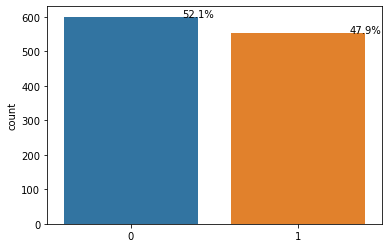

In [5]:
def count_with_percent(rowdata):
    ax = sns.countplot(x=rowdata)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(rowdata))
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.show()

count_with_percent(y_val)

3. Setup and train BERT model

In [6]:
device = 'cuda' #'cpu'
model = BertClassifier(MODEL, n_classes=2, device=device)

In [7]:
model.train(train, valid, lr=1e-5, n_epochs=10)

Epoch: 1/10
Validation loss: 0.536240, Accuracy: 0.855903
Epoch: 2/10
Validation loss: 0.573372, Accuracy: 0.864583
Epoch: 3/10
Validation loss: 0.613925, Accuracy: 0.870660
Epoch: 4/10
Validation loss: 0.603447, Accuracy: 0.887153
Epoch: 5/10
Validation loss: 0.683592, Accuracy: 0.881076
Epoch: 6/10
Validation loss: 0.921799, Accuracy: 0.856771
Epoch 00007: reducing learning rate of group 0 to 5.0000e-06.
Epoch: 7/10
Validation loss: 0.844042, Accuracy: 0.866319
Epoch: 8/10
Validation loss: 0.937705, Accuracy: 0.870660
Epoch: 9/10
Validation loss: 1.095614, Accuracy: 0.853299
Epoch: 10/10
Validation loss: 1.059343, Accuracy: 0.861111


3. Score and visualize results

F1 metric score: 0.697


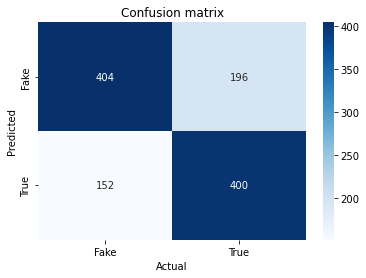

In [8]:
y_pred = model.predict(valid, from_pretrained=True)

print('F1 metric score: %.3f' %f1_score(y_val, y_pred))

notation = ['Fake', 'True']
cm = pd.DataFrame(confusion_matrix(y_val, y_pred), 
                  index=notation, columns=notation)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='',
            xticklabels=notation, yticklabels=notation)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix')
plt.show()

4. Make prediction file

In [9]:
y_pred = model.predict(test)

test_df.iloc[:, 1] = y_pred
test_df.to_csv('predictions.tsv', sep='\t')